In [2]:
import os
import torch
from torch import nn
import torchvision 


from torchvision import datasets, transforms
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

In [3]:

import numpy as np
from PIL import Image
from glob import glob
from time import time
import torch.optim as optim
from torchvision import datasets as dsets
from torchvision import transforms as trans
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# 2.1 CNN for Prdestrian Detection

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Load Dataset

In [5]:
 
# Hyperparameters 
num_epochs = 20 
batch_size = 8
learning_rate = 0.01 

newdata_dir = '../Question1_dataset/newImages'

# Data Transformations
data_transform = transforms.Compose([
    transforms.Resize([64,64]),  # Resize as images are of varying sizes
  #  transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(),  # Add random flips
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def dynamic_padding_collate_fn(batch):
    """Pad images to the maximum size within a batch (assumes a list of tuples (image, label))"""
    max_width = max(item[0].size(-1) for item in batch)
    max_height = max(item[0].size(-2) for item in batch)

    padded_images = []
    labels = []

    for image, label in batch:
        padding = (0, max_width - image.size(-1), 0, max_height - image.size(-2))  # Calculate dynamic padding
        padded_image = F.pad(image, padding, mode='constant', value=0)  # Apply padding
        padded_images.append(padded_image)
        labels.append(label)

    return torch.stack(padded_images), torch.tensor(labels) 
# ----- Load datasets using ImageFolder -----

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(newdata_dir, 'train'), transform=data_transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(newdata_dir, 'val'), transform=data_transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(newdata_dir, 'test'), transform=data_transform)
,
# ----- Create DataLoaders -----

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ,  collate_fn=dynamic_padding_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset.classes)

print("Datasets loaded successfully!")


    

['Car', 'Cyclist', 'Pedestrian', 'Van']
Datasets loaded successfully!


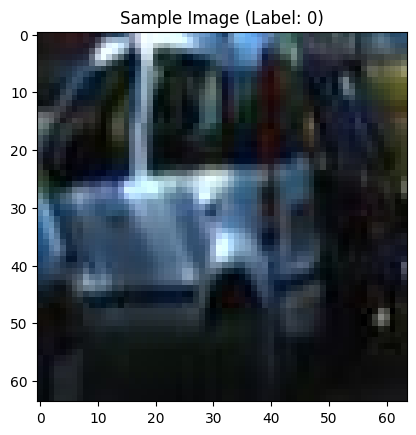

In [6]:



def display_sample_image(dataset_loader):
    """Displays a single image from the given dataset loader"""
    
    # Get a batch of data (assuming you want an image from the train_loader)
    images, labels = next(iter(dataset_loader))

    # Select a sample image and its label 
    image = images[0]
    label = labels[0]   

    # Reverse any normalization
    if 'Normalize' in str(dataset_loader.dataset.transform):
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image * std[:, None, None] + mean[:, None, None]  

    # Convert the tensor to a NumPy array (may or may not be necessary)
    image_array = image.numpy()

    # Transpose to arrange channels for Matplotlib
    image_array = image_array.transpose(1, 2, 0)  

    # Clip to [0, 1] in case normalization reversal pushed values outside this range
    image_array = np.clip(image_array, 0, 1)

    # Display using Matplotlib
    plt.imshow(image_array)
    plt.title(f'Sample Image (Label: {label})')
    plt.show()

# Example usage:
display_sample_image(train_loader) 


In [7]:


# Simple CNN Model 
class SimplePedestrianClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Conv2d Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(7, 7)) 
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32768, 128),  # Adjust based on your model
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output before passing to linear layers
        x = self.linear_layers(x)
        return x


In [8]:
# CNN Model 
class PedestrianClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Conv2d Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Conv2d Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*64, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x



In [ ]:
#CNN model with Droupout:
class PedestrianClassifierwithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Conv2d Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(7, 7)) 
        self.linear_layers = nn.Sequential(
            nn.Flatten(),     
            nn.Linear(7 * 7 * 64, 1024), 
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Add dropout
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.adaptive_pool(x) 
        x = self.linear_layers(x)
        return x

# Instantiate the model (with L2 regularization)
model = PedestrianClassifier()
criterion = nn.BCELoss(weight=torch.tensor([0.001]).to(device)) # Example with L2 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)  # Add weight_decay

In [9]:
# Model, loss function, optimizer
model = PedestrianClassifier()
# Add L2 regularization
criterion = nn.BCELoss(weight=torch.tensor([0.001]).to(device)) # Example with L2 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Device configuration (use GPU if available)
if torch.backends.mps.is_available():
    device = torch.device("mps")  
else:
    device = torch.device('cpu')  # Fallback to CPU if MPS is not available
model.to(device)

# Training Loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        # Filter for pedestrian (index 2) and non-pedestrian 
        pedestrian_filter = labels == 2
        non_pedestrian_filter = labels != 2
        filtered_images = images[pedestrian_filter | non_pedestrian_filter]
        filtered_labels = labels[pedestrian_filter | non_pedestrian_filter]

        # Re-label non-pedestrians as 1 
        filtered_labels[filtered_labels != 2] = 1 
        filtered_labels[filtered_labels == 2] = 0
        filtered_labels = filtered_labels.long()

        # Forward pass
        outputs = model(filtered_images)
        loss = criterion(outputs, filtered_labels.view(-1, 1).float())
  

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
       
        # Print progress
        if (i + 1) % 50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for filtered_images, filtered_labels in val_loader:
            filtered_images, filtered_labels = filtered_images.to(device), filtered_labels.to(device)
            outputs = model(filtered_images)
            _, predicted = torch.max(outputs.data, 1)
            total += filtered_labels.size(0)
            correct += (predicted == filtered_labels).sum().item()

        val_accuracy = 100 * correct / total
        print('Validation Accuracy of the model on the validation images: {} %'.format(val_accuracy))
    model.train()  # Set model back to training mode    
        

Epoch [1/20], Step [50/212], Loss: 0.0000
Epoch [1/20], Step [100/212], Loss: 0.0000
Epoch [1/20], Step [150/212], Loss: 0.0125
Epoch [1/20], Step [200/212], Loss: 0.0125
Validation Accuracy of the model on the validation images: 82.87292817679558 %
Epoch [2/20], Step [50/212], Loss: 0.0125
Epoch [2/20], Step [100/212], Loss: 0.0125
Epoch [2/20], Step [150/212], Loss: 0.0125
Epoch [2/20], Step [200/212], Loss: 0.0125
Validation Accuracy of the model on the validation images: 82.87292817679558 %
Epoch [3/20], Step [50/212], Loss: 0.0000
Epoch [3/20], Step [100/212], Loss: 0.0000
Epoch [3/20], Step [150/212], Loss: 0.0125
Epoch [3/20], Step [200/212], Loss: 0.0375
Validation Accuracy of the model on the validation images: 82.87292817679558 %
Epoch [4/20], Step [50/212], Loss: 0.0250
Epoch [4/20], Step [100/212], Loss: 0.0125
Epoch [4/20], Step [150/212], Loss: 0.0125
Epoch [4/20], Step [200/212], Loss: 0.0375
Validation Accuracy of the model on the validation images: 82.87292817679558 %


In [10]:
import matplotlib.pyplot as plt
import itertools 

def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

  # Normalize confusion matrix values to percentages
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Display numbers in each cell
    threshold = cm.max() / 2.  # Heuristic for text color visibility
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.0f}", 
                ha="center", va="center",
                color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
 
      

tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])
{1}
{0}
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tenso

/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


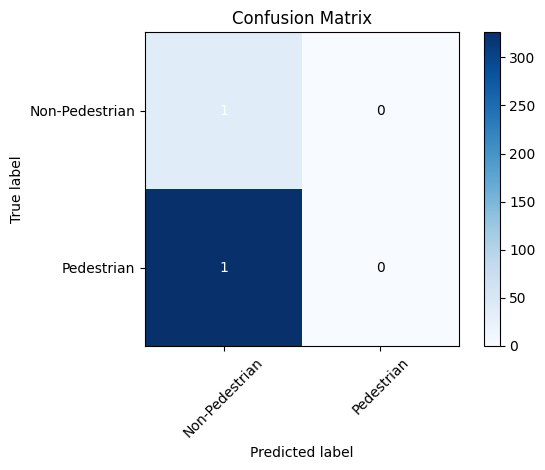

In [11]:
# Testing
model.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []  # Store true labels
    y_pred = []  # Store predictions

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Filter for pedestrian (index 2) and non-pedestrian 
        pedestrian_filter = labels == 2
        non_pedestrian_filter = labels != 2
        filtered_images = images[pedestrian_filter | non_pedestrian_filter]
        filtered_labels = labels[pedestrian_filter | non_pedestrian_filter]

        # Re-label non-pedestrians as 1 
        filtered_labels[filtered_labels != 2] = 1
        filtered_labels[filtered_labels == 2] = 0
        filtered_labels = filtered_labels.long()
        
        outputs = model(filtered_images)
        _, predicted = torch.max(outputs.data, 1)
        total += filtered_labels.size(0)
        correct += (predicted == filtered_labels).sum().item()
        print(filtered_labels[:10])  # Print the first 10 filtered labels
        print(predicted[:10])  # Print the first 10 predictions
        print(set(filtered_labels.cpu().numpy().tolist()))  # Unique labels
        print(set(predicted.cpu().numpy().tolist()))
        # Store for metrics calculation
        y_true.extend(filtered_labels.cpu().numpy().tolist()) 
        y_pred.extend(predicted.cpu().numpy().tolist())

    test_accuracy = 100 * correct / total
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) 

    print('Accuracy of the model on the test images: {} %'.format(test_accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1-Score: {:.4f}'.format(f1))
    cm = confusion_matrix(y_true, y_pred) 

    # Print the confusion matrix
    print('Confusion Matrix:')
    print(cm)

    plot_confusion_matrix(cm, class_names=['Non-Pedestrian', 'Pedestrian'])

In [59]:

from sklearn.metrics import confusion_matrix

y_true, y_pred = [], []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[300   0   0   0]
 [  6   0   0   0]
 [ 37   0   0   0]
 [ 20   0   0   0]]


# 2.2 Improving performance through data augmentation 

## Tutorial 3 Code

In [83]:
# Model Hyperparameters
image_size = 32*32
num_classes = 62
num_hidden_unit = 100

batch_size = 32 
learning_rate = 1
itr = 4 


In [84]:
cuda = False
torch.manual_seed(0)
if torch.cuda.is_available() and cuda:
    torch.cuda.manual_seed_all(0)
    FloatType = torch.cuda.FloatTensor
    LongType = torch.cuda.LongTensor
else:
    FloatType = torch.FloatTensor
    LongType = torch.LongTensor

In [85]:
# Define transformation
transforms = trans.Compose([trans.Grayscale(), trans.Resize([32,32]), trans.ToTensor(), trans.Normalize(mean=(0.5,), std = (0.5,))])

In [96]:
# Loading dataset
class BelgiumTSCDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.paths = glob(os.path.join(self.root, '**', "*.png"))

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        img = self.transform(Image.open(path))
        label = int(path.split(os.path.sep)[-2])
        return img, label
# Loading dataset
train_data = BelgiumTSCDataset(root='../Tutorial 3 - Introduction to Neural Networks and CNNs/data/BelgiumTSC_Training/Training', transform= transforms)
test_data = BelgiumTSCDataset(root='../Tutorial 3 - Introduction to Neural Networks and CNNs/data/BelgiumTSC_Testing/Testing', transform= transforms)


# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 1)
    



torch.Size([1, 32, 32])
torch.Size([32, 32])


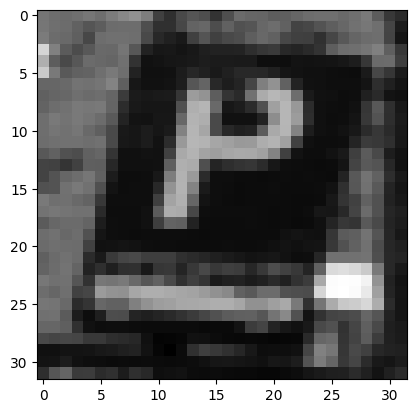

In [87]:
image = train_data[0][0]

print(image.shape)

image = image.view(32,32)


print(image.shape)

plt.imshow(image, cmap='gray')

## Create Model

In [88]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.normal_(mean=0,std=1e-2)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.normal_(mean=0,std=1e-2)

In [89]:
class TwoLayerNN(nn.Module):
    def __init__(self, num_input=32*32, num_class=62, num_hidden_unit = 100):
        super(TwoLayerNN, self).__init__()
        self.num_input = num_input
        self.num_class = num_class
        self.num_hidden_unit = num_hidden_unit
        
        # Defining the layers:
        self.fc1 = nn.Linear(num_input, num_hidden_unit)
        self.fc2 = nn.Linear(num_hidden_unit, num_class)

    def forward(self, x):
        x = x.view(-1, self.num_input)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train Function


In [90]:
def train_model(model, optimizer, train_loader, loss_func, epoch, vis_step = 20):
    # Number of samples with correct classification
    num_hit = 0
    # total size of train data
    total = len(train_loader.dataset)
    # number of batch
    num_batch = np.ceil(total/batch_size)
    accumulative_loss = 0
    # Training loop over batches of data on train dataset
    for batch_idx, (image, labels) in enumerate(train_loader):
        # 1. Clearing previous gradient values.
        optimizer.zero_grad()
        # 2. feeding images to model (forward method will be computed)
        output = model(image)
        # 3. Calculating the loss value
        loss = loss_func(output, labels)
        # 4. Calculating new grdients given the loss value
        loss.backward()
        # 5. Updating the weights
        optimizer.step()
        # 6. logging (Optional)
        if batch_idx % vis_step == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(image),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.data.item()))
    # Validation Phase on train dataset
    for batch_idx, (image, labels) in enumerate(train_loader):
        output = model(image)
        _ , pred_label = output.data.max(dim=1)
        num_hit += (pred_label == labels.data).sum()
    train_accuracy = (num_hit.item() / total)
    print("Epoch: {}, Training Accuracy: {:.2f}%".format(epoch, 100. * train_accuracy))
    return 100. * train_accuracy

In [97]:
def eval_model(model, test_loader, epoch):
    num_hit = 0
    total = len(test_loader.dataset)
    
    # Training loop over batches of data on train dataset
    for batch_idx, (image, labels) in enumerate(test_loader):
        # 1. Clearing previous gradient values.
      
        # 2. feeding images to model (forward method will be computed)
        output = model(image)
        # 3. Calculating the loss value
        loss = loss_func(output, labels)
        # 4. Calculating new grdients given the loss value
        
        # 5. Updating the weights
        
        # 6. logging (Optional)
       
    # Validation Phase on train dataset
    for batch_idx, (image, labels) in enumerate(test_loader):
        output = model(image)
        _ , pred_label = output.data.max(dim=1)
        num_hit += (pred_label == labels.data).sum()
        total = float(len(test_loader.dataset)) 
    test_accuracy = (num_hit).item() / total) 

    print("Epoch: {}, Testing Accuracy: {:.2f}%".format(epoch, 100. * test_accuracy))
    return 100. * test_accuracy


In [92]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=1,
        	                   out_channels=6,
            				   kernel_size=(5,5),
            				   stride=(1,1))
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2))
        
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1))

      # Fully Connected Layers: 
        self.fc6 = nn.Linear(in_features=120, out_features=84)
        self.fc7 = nn.Linear(in_features=84, out_features=62)  
        
    def forward(self,x):
        x = x.view([-1, 1, 32, 32])
        x = nn.functional.relu(self.conv1(x))
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool4(x)
        x = nn.functional.relu(self.conv5(x))
        x = x.view(-1, 120)
        x = nn.functional.relu(self.fc6(x))
        x = self.fc7(x)
        return x

In [98]:
torch.manual_seed(0)
# Training Hyperparameters
batch_size = 32 
learning_rate = 0.01
itr = 4 


# Complete following lines
# 1. Instantiate from the model class 

CNNmodel = ConvNet()
# 2. Initialize model's weight
CNNmodel.apply(weights_init)


# 3. Define optimizer and loss function

optimizer = optim.SGD(params = CNNmodel.parameters(), lr = learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

# 4. Write the training loop
train_acc = []
test_acc = []
total_time = 0
for epoch in range(itr):
    start = time()
    tr_acc = train_model(CNNmodel, optimizer, train_loader, loss_func, epoch+1)
    ts_acc = eval_model(CNNmodel, test_loader, epoch+1)
    train_acc.append(tr_acc)
    test_acc.append(ts_acc)
    end = time()
    total_time += end-start
print("Training and evaluation finished in:", total_time, "sec.")

Train Epoch: 1 [0/4575 (0%)]	Loss: 4.734022
Train Epoch: 1 [640/4575 (14%)]	Loss: 4.027958
Train Epoch: 1 [1280/4575 (28%)]	Loss: 3.894477
Train Epoch: 1 [1920/4575 (42%)]	Loss: 3.520956
Train Epoch: 1 [2560/4575 (56%)]	Loss: 3.296435
Train Epoch: 1 [3200/4575 (70%)]	Loss: 3.359445
Train Epoch: 1 [3840/4575 (84%)]	Loss: 2.857586
Train Epoch: 1 [4480/4575 (98%)]	Loss: 3.211948
Epoch: 1, Training Accuracy: 35.26%
Epoch: 1, Testing Accuracy: 35.08%
Train Epoch: 2 [0/4575 (0%)]	Loss: 2.740775
Train Epoch: 2 [640/4575 (14%)]	Loss: 2.534137
Train Epoch: 2 [1280/4575 (28%)]	Loss: 2.125415
Train Epoch: 2 [1920/4575 (42%)]	Loss: 2.543124
Train Epoch: 2 [2560/4575 (56%)]	Loss: 2.179187
Train Epoch: 2 [3200/4575 (70%)]	Loss: 2.242042
Train Epoch: 2 [3840/4575 (84%)]	Loss: 2.124968
Train Epoch: 2 [4480/4575 (98%)]	Loss: 2.032575
Epoch: 2, Training Accuracy: 54.34%
Epoch: 2, Testing Accuracy: 51.98%
Train Epoch: 3 [0/4575 (0%)]	Loss: 1.658428
Train Epoch: 3 [640/4575 (14%)]	Loss: 1.387848
Train Epo

## Evaluate the Model with the given Tes_Subset Containing Augmented images 

In [99]:
#Load the new test set
test_subset_data = BelgiumTSCDataset(root='../Tutorial 3 - Introduction to Neural Networks and CNNs/data/Test_subset', transform= transforms)
test_subset_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 1)


torch.Size([1, 32, 32])
torch.Size([32, 32])


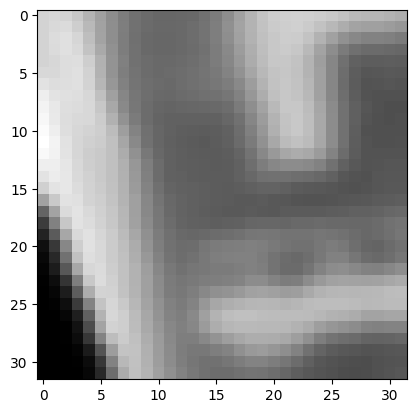

In [101]:
image1 = test_subset_data[0][0]

print(image1.shape)

image1 = image1.view(32,32)


print(image1.shape)

plt.imshow(image1, cmap='gray')

In [110]:
CNNmodel.apply(weights_init)
tests_subset_acc=[]
total_time = 0
for epoch in range(1):
    start = time()
    
    ts_subset_acc = eval_model(CNNmodel, test_subset_loader, epoch+1)
    test_subset_acc.append(ts_subset_acc)
    end = time()
    total_time += end-start
print("evaluation finished in:", total_time, "sec.")

Epoch: 1, Testing Accuracy: 1.90%
evaluation finished in: 10.044610023498535 sec.


In [115]:
# Define data augmentation transformations
data_transforms = trans.Compose([
    trans.Grayscale(),        # Assuming the original dataset is in color
    trans.Resize([32, 32]),
    trans.RandomHorizontalFlip(p=0.5),  # Add random flips for variability
    trans.RandomRotation(degrees=15),   # Add random rotations
    trans.ToTensor(),
    trans.Normalize(mean=(0.5,), std=(0.5,)) 
])

# Update the Dataset loading and DataLoader creation
train_subset_data = BelgiumTSCDataset(root='./data/BelgiumTSC_Training/Training', transform=data_transforms)
train_subset_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)

In [117]:
# 1. Instantiate from the model class 
CNNmodel2= ConvNet()
# 2. Initialize model's weight
CNNmodel2.apply(weights_init)
# 3. Define optimizer and loss function

optimizer = optim.SGD(params = CNNmodel2.parameters(), lr = learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

# 4. Write the training loop
train_subset_acc = []
test_subset_acc = []
total_time = 0
for epoch in range(itr):
    start = time()
    tr_subset_acc = train_model(CNNmodel2, optimizer, train_subset_loader, loss_func, epoch+1)
    ts_subset_acc = eval_model(CNNmodel2, test_subset_loader, epoch+1)
    train_subset_acc.append(tr_subset_acc)
    test_subset_acc.append(ts_subset_acc)
    end = time()
    total_time += end-start
print("Training and evaluation finished in:", total_time, "sec.")


Train Epoch: 1 [0/4575 (0%)]	Loss: 4.362205
Train Epoch: 1 [640/4575 (14%)]	Loss: 4.091007
Train Epoch: 1 [1280/4575 (28%)]	Loss: 3.659576
Train Epoch: 1 [1920/4575 (42%)]	Loss: 3.429806
Train Epoch: 1 [2560/4575 (56%)]	Loss: 2.965470
Train Epoch: 1 [3200/4575 (70%)]	Loss: 3.465729
Train Epoch: 1 [3840/4575 (84%)]	Loss: 2.701796
Train Epoch: 1 [4480/4575 (98%)]	Loss: 2.429746
Epoch: 1, Training Accuracy: 43.04%
Epoch: 1, Testing Accuracy: 39.88%
Train Epoch: 2 [0/4575 (0%)]	Loss: 2.471794
Train Epoch: 2 [640/4575 (14%)]	Loss: 2.725517
Train Epoch: 2 [1280/4575 (28%)]	Loss: 2.870820
Train Epoch: 2 [1920/4575 (42%)]	Loss: 2.484716
Train Epoch: 2 [2560/4575 (56%)]	Loss: 2.294783
Train Epoch: 2 [3200/4575 (70%)]	Loss: 2.608719
Train Epoch: 2 [3840/4575 (84%)]	Loss: 2.026847
Train Epoch: 2 [4480/4575 (98%)]	Loss: 2.192122
Epoch: 2, Training Accuracy: 56.90%
Epoch: 2, Testing Accuracy: 53.61%
Train Epoch: 3 [0/4575 (0%)]	Loss: 2.182225
Train Epoch: 3 [640/4575 (14%)]	Loss: 1.599090
Train Epo